In [8]:
# Cell 1: Imports and Setup
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
# Set plot style
sns.set_style("whitegrid")

In [13]:
# Cell 2: Load and Preprocess Data
print("Loading and preprocessing data...")
df = pd.read_csv('../data/raw/WA_Fn-UseC_-Telco-Customer-Churn.csv')

# Basic preprocessing similar to features.py
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df.dropna(inplace=True)
df['Churn'] = df['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)

# One-hot encode categorical features for modeling
df_processed = pd.get_dummies(df, drop_first=True)

# FIX #1: Check if 'customerID' exists before trying to drop it.
if 'customerID' in df_processed.columns:
    df_processed = df_processed.drop(columns=['customerID'])

print("Data loaded.")

Loading and preprocessing data...
Data loaded.


In [14]:
# Cell 3: Simulate Experimental A/B Test Data
print("\nSimulating historical A/B test data...")
np.random.seed(42)

# --- Create a 'treatment' group (1 = got an offer, 0 = no offer)
df_processed['treatment'] = np.random.randint(0, 2, df_processed.shape[0])

# --- Simulate the true outcome (churn) based on the treatment
# Rule: The offer is highly effective for "Month-to-month" customers,
# and slightly effective for everyone else.

# Base churn probability is the original churn data
churn_prob = df_processed['Churn']

# Define treatment effects
general_reduction = 0.7  # A 30% churn reduction for everyone who gets an offer
bonus_reduction = 0.5  # An extra 50% churn reduction for month-to-month customers

# Apply the effects to calculate the new churn probability for the treated group
churn_prob_treated = churn_prob * general_reduction

# FIX #2: Identify month-to-month customers by checking if the other contract columns are 0.
is_month_to_month = (df_processed['Contract_One year'] == 0) & (df_processed['Contract_Two year'] == 0)
churn_prob_treated[is_month_to_month] *= bonus_reduction

# Create the final simulated outcome based on these probabilities
# Control group's outcome is their original churn status
df_processed['churn_outcome'] = df_processed['Churn']

# For the treatment group, their outcome is a random event based on the new, lower churn probability
is_treated = (df_processed['treatment'] == 1)
df_processed.loc[is_treated, 'churn_outcome'] = (np.random.rand(is_treated.sum()) < churn_prob_treated[is_treated]).astype(int)

print("Simulation complete.")
print("Example of simulated data:")
print(df_processed[['Churn', 'treatment', 'Contract_One year', 'churn_outcome']].head())



Simulating historical A/B test data...
Simulation complete.
Example of simulated data:
   Churn  treatment  Contract_One year  churn_outcome
0      0          0              False              0
1      0          1               True              0
2      1          0              False              1
3      0          0               True              0
4      1          0              False              1


In [15]:
# Cell 4: Build the Two-Model Uplift Approach
print("\nBuilding the Two-Model Uplift model...")

# Separate features (X) from the target (y) and treatment indicator (T)
X = df_processed.drop(columns=['Churn', 'churn_outcome', 'treatment'])
y = df_processed['churn_outcome']
T = df_processed['treatment']

# Split data into treatment and control groups
X_treat, y_treat = X[T == 1], y[T == 1]
X_ctrl, y_ctrl = X[T == 0], y[T == 0]

# --- Train a model on the Treatment group ---
print("Training Treatment Model...")
model_treat = XGBClassifier(objective='binary:logistic', use_label_encoder=False, eval_metric='logloss', random_state=42)
model_treat.fit(X_treat, y_treat)

# --- Train a model on the Control group ---
print("Training Control Model...")
model_ctrl = XGBClassifier(objective='binary:logistic', use_label_encoder=False, eval_metric='logloss', random_state=42)
model_ctrl.fit(X_ctrl, y_ctrl)

print("Uplift models trained.")



Building the Two-Model Uplift model...
Training Treatment Model...


c:\Users\syedm\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:183: UserWarning: [19:58:10] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Training Control Model...


c:\Users\syedm\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:183: UserWarning: [19:58:16] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Uplift models trained.


In [16]:
# Cell 5: Calculate Uplift Score for All Customers
print("\nCalculating uplift scores for all customers...")

# Predict the probability of churn for ALL customers using the Control model
# This gives us: P(Churn | No Offer)
p_ctrl = model_ctrl.predict_proba(X)[:, 1]

# Predict the probability of churn for ALL customers using the Treatment model
# This gives us: P(Churn | Offer)
p_treat = model_treat.predict_proba(X)[:, 1]

# Uplift = P(Churn | No Offer) - P(Churn | Offer)
# This score represents the reduction in churn probability due to the offer.
df_processed['uplift_score'] = p_ctrl - p_treat


Calculating uplift scores for all customers...


In [17]:
# Cell 6: Analyze the Uplift Results
print("\nAnalysis of Uplift Scores:")

# Add original descriptive columns back for better interpretation
df_processed['original_contract'] = df['Contract']

print("\n--- Top 10 Customers to Target (The 'Persuadables') ---")
# These are the customers where the offer has the biggest positive impact
print(df_processed.sort_values('uplift_score', ascending=False)[['original_contract', 'uplift_score']].head(10))

print("\n--- Bottom 10 Customers to AVOID Targeting ---")
# These customers have low or negative uplift.
# Negative Uplift: The offer might actually INCREASE their chance of churning (e.g., annoying them).
# Zero Uplift: These are "Sure Things" (won't churn anyway) or "Lost Causes" (will churn anyway).
print(df_processed.sort_values('uplift_score', ascending=False)[['original_contract', 'uplift_score']].tail(10))


Analysis of Uplift Scores:

--- Top 10 Customers to Target (The 'Persuadables') ---
     original_contract  uplift_score
4597    Month-to-month      0.962021
5943    Month-to-month      0.955158
3473    Month-to-month      0.948897
2438    Month-to-month      0.946145
2246    Month-to-month      0.945595
3462    Month-to-month      0.943773
1176    Month-to-month      0.938192
6886    Month-to-month      0.935820
6232    Month-to-month      0.932369
5798    Month-to-month      0.932111

--- Bottom 10 Customers to AVOID Targeting ---
     original_contract  uplift_score
5967    Month-to-month     -0.780794
5946          One year     -0.787527
5050          Two year     -0.788573
5482          One year     -0.791819
4296    Month-to-month     -0.801658
641     Month-to-month     -0.807254
4149          Two year     -0.833807
2780          One year     -0.845982
6972          One year     -0.850409
6333          One year     -0.870616


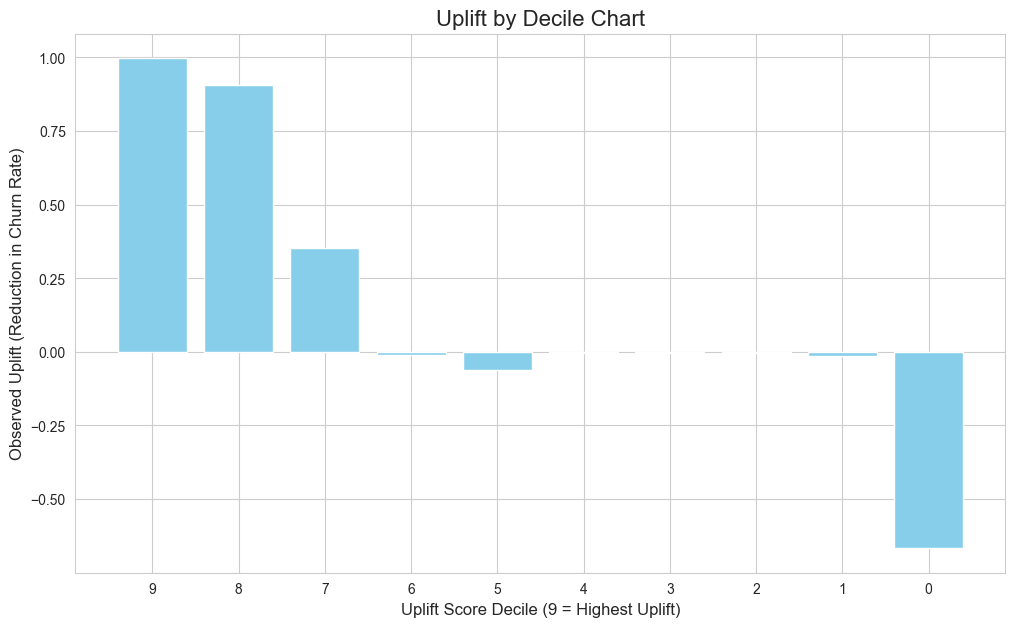


This chart shows the real-world impact. Targeting customers in the top deciles (e.g., 8, 9) gives a massive reduction in churn.
Targeting customers in the bottom deciles gives almost no benefit, saving the company money on wasted offers.


In [18]:
# Cell 7: Visualize the Uplift by Decile
# This is a standard way to show the business value of an uplift model

# Create deciles based on the uplift score
df_processed['uplift_decile'] = pd.qcut(df_processed['uplift_score'], 10, labels=False, duplicates='drop')

# Calculate the average observed churn rate in each decile for both treatment and control groups
uplift_by_decile = df_processed.groupby('uplift_decile').agg(
    avg_churn_treat=('churn_outcome', lambda x: x[df_processed.loc[x.index, 'treatment'] == 1].mean()),
    avg_churn_ctrl=('churn_outcome', lambda x: x[df_processed.loc[x.index, 'treatment'] == 0].mean())
).sort_index(ascending=False)

# Calculate the true uplift in each decile
uplift_by_decile['true_uplift'] = uplift_by_decile['avg_churn_ctrl'] - uplift_by_decile['avg_churn_treat']

# Plot the results
plt.figure(figsize=(12, 7))
plt.bar(uplift_by_decile.index, uplift_by_decile['true_uplift'], color='skyblue')
plt.title('Uplift by Decile Chart', fontsize=16)
plt.xlabel('Uplift Score Decile (9 = Highest Uplift)', fontsize=12)
plt.ylabel('Observed Uplift (Reduction in Churn Rate)', fontsize=12)
plt.xticks(uplift_by_decile.index)
plt.gca().invert_xaxis() # Highest uplift is on the left
plt.show()

print("\nThis chart shows the real-world impact. Targeting customers in the top deciles (e.g., 8, 9) gives a massive reduction in churn.")
print("Targeting customers in the bottom deciles gives almost no benefit, saving the company money on wasted offers.")